In [2]:


import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
!pip install changefinder
import changefinder
from sklearn.metrics import f1_score
!pip install shap
import shap
shap.initjs()
from tabulate import tabulate
from IPython.display import HTML, display

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.7 MB/s eta 0:00:00
  Created wheel for changefinder: filename=changefinder-0.3-py3-none-any.whl size=3824 sha256=ae3751beb573d8df98a5a2315446d3b62c2d3cae8af9b00853d96d8fb3ef2e90
  Stored in directory: /root/.cache/pip/wheels/f2/fa/e8/f408bd08e5ec7efe062c717bc3997bde871f42a2dc1e133b2b
Successfully built changefinder
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.0 MB/s eta 0:00:00


In [7]:
# prompt: Print versions of above installed packages

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import os
import scipy as sp
import statsmodels as sm
import sklearn as sk
import changefinder as cf
import shap as sh

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", mpl.__version__)
print("Seaborn version:", sns.__version__)
print("SciPy version:", sp.__version__)
print("Statsmodels version:", sm.__version__)
print("Scikit-learn version:", sk.__version__)
#print("Changefinder version:", cf.__version__)
print("SHAP version:", sh.__version__)


NumPy version: 1.25.2
Pandas version: 2.0.3
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
SciPy version: 1.11.4
Statsmodels version: 0.14.2
Scikit-learn version: 1.2.2
SHAP version: 0.46.0


In [6]:
!pip show changefinder



Name: changefinder
Version: 0.3
Summary: Online Change-Point Detection Library based on ChangeFinder Algorithm.
Home-page: https://bitbucket.org/aihara/changefinder/
Author: Shunsuke Aihara
Author-email: s.aihara gmail com
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: nose, numpy, scipy, statsmodels
Required-by: 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving temperature_dataset_sorted.csv to temperature_dataset_sorted.csv


In [ ]:
df = pd.read_csv("temperature_dataset_sorted.csv")

In [ ]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    200000 non-null  object 
 1   temperature  200000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


,temperature
count,200000.000000
mean,35.942502
std,13.467782
min,2.000328
25%,26.706362
50%,35.006916
75%,43.283500
max,99.998700


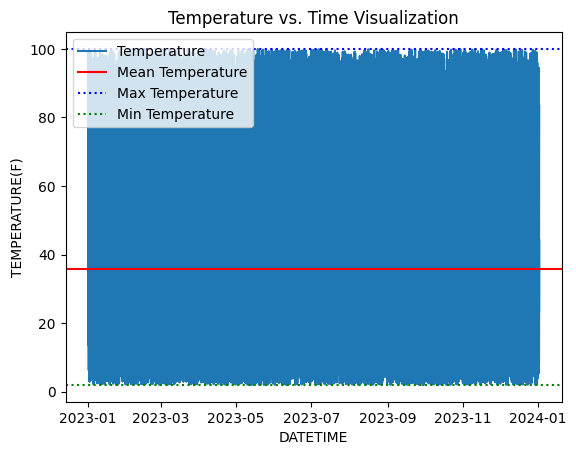

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pd.to_datetime(df['timestamp']),df['temperature'],label='Temperature')
plt.axhline(y = df['temperature'].mean(), color = 'r', linestyle = '-',label='Mean Temperature')
plt.axhline(y = df['temperature'].max(), color = 'b', linestyle = 'dotted',label='Max Temperature')
plt.axhline(y = df['temperature'].min(), color = 'g', linestyle = 'dotted',label='Min Temperature')
plt.xlabel('DATETIME')
plt.ylabel('TEMPERATURE(F)')
plt.legend()
plt.title('Temperature vs. Time Visualization')
plt.show()

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
#is anomaly? : True => 1, False => 0
df['anomaly'] = 0
df['anomaly'] = df['temperature'].apply(lambda x: 0 if 10 <= x <= 50 else 1)
df.head()

,timestamp,temperature,anomaly
0,2023-01-01 00:01:00,28.394896,0
1,2023-01-01 00:02:00,98.954528,1
2,2023-01-01 00:11:00,32.103059,0
3,2023-01-01 00:20:00,31.011109,0
4,2023-01-01 00:22:00,26.024300,0


In [ ]:
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)
df.head()

,timestamp,temperature,anomaly,year,month,day,hour,minute
0,2023-01-01 00:01:00,28.394896,0,2023,1,1,0,1
1,2023-01-01 00:02:00,98.954528,1,2023,1,1,0,2
2,2023-01-01 00:11:00,32.103059,0,2023,1,1,0,11
3,2023-01-01 00:20:00,31.011109,0,2023,1,1,0,20
4,2023-01-01 00:22:00,26.024300,0,2023,1,1,0,22


In [ ]:
df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head()

,temperature,anomaly,year,month,day,hour,minute
timestamp,,,,,,,
2023-01-01 00:01:00,28.394896,0,2023,1,1,0,1
2023-01-01 00:02:00,98.954528,1,2023,1,1,0,2
2023-01-01 00:11:00,32.103059,0,2023,1,1,0,11
2023-01-01 00:20:00,31.011109,0,2023,1,1,0,20
2023-01-01 00:22:00,26.024300,0,2023,1,1,0,22


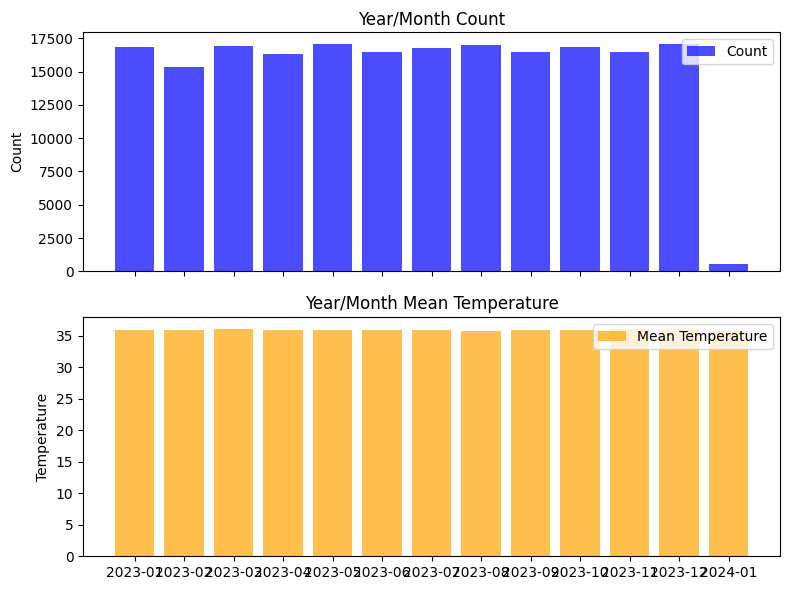

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

grouped = df.groupby(['year', 'month'])
count = grouped['temperature'].count()
mean = grouped['temperature'].mean()

year_month_pairs = [f"{year}-{month:02}" for year, month in count.index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Bar plot for count
ax1.bar(year_month_pairs, count, color='blue', alpha=0.7, label='Count')
ax1.set_ylabel('Count')
ax1.set_title('Year/Month Count')
ax1.legend()

# Bar plot for mean temperature
ax2.bar(year_month_pairs, mean, color='orange', alpha=0.7, label='Mean Temperature')
ax2.set_ylabel('Temperature')
ax2.set_title('Year/Month Mean Temperature')
ax2.legend()

plt.tight_layout()
plt.show()

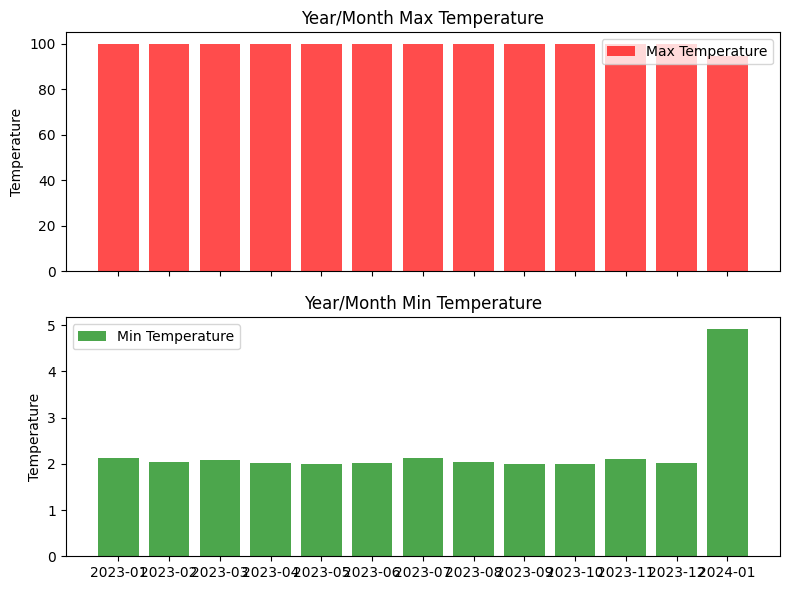

In [ ]:
year_maxmin = df.groupby(['year', 'month'])['temperature'].agg(['min', 'max'])

year_month_pairs = [f"{year}-{month:02}" for year, month in year_maxmin.index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Bar plot for max temperature
ax1.bar(year_month_pairs, year_maxmin['max'], color='red', alpha=0.7, label='Max Temperature')
ax1.set_ylabel('Temperature')
ax1.set_title('Year/Month Max Temperature')
ax1.legend()

# Bar plot for min temperature
ax2.bar(year_month_pairs, year_maxmin['min'], color='green', alpha=0.7, label='Min Temperature')
ax2.set_ylabel('Temperature')
ax2.set_title('Year/Month Min Temperature')
ax2.legend()

plt.tight_layout()
plt.show()

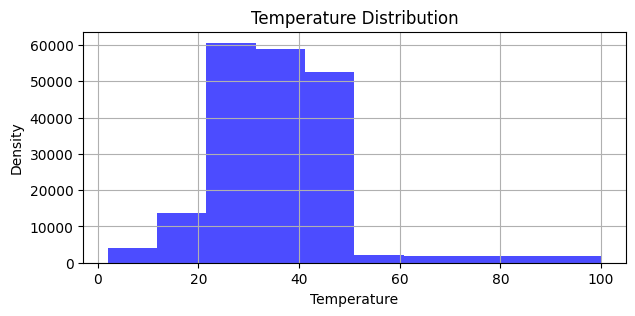

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

# histogram for the temperature distribution
ax.hist(df['temperature'], bins=10, color='blue', alpha=0.7)
ax.set_title("Temperature Distribution")
ax.set_xlabel("Temperature")
ax.set_ylabel("Density")
ax.grid(True)

plt.show()


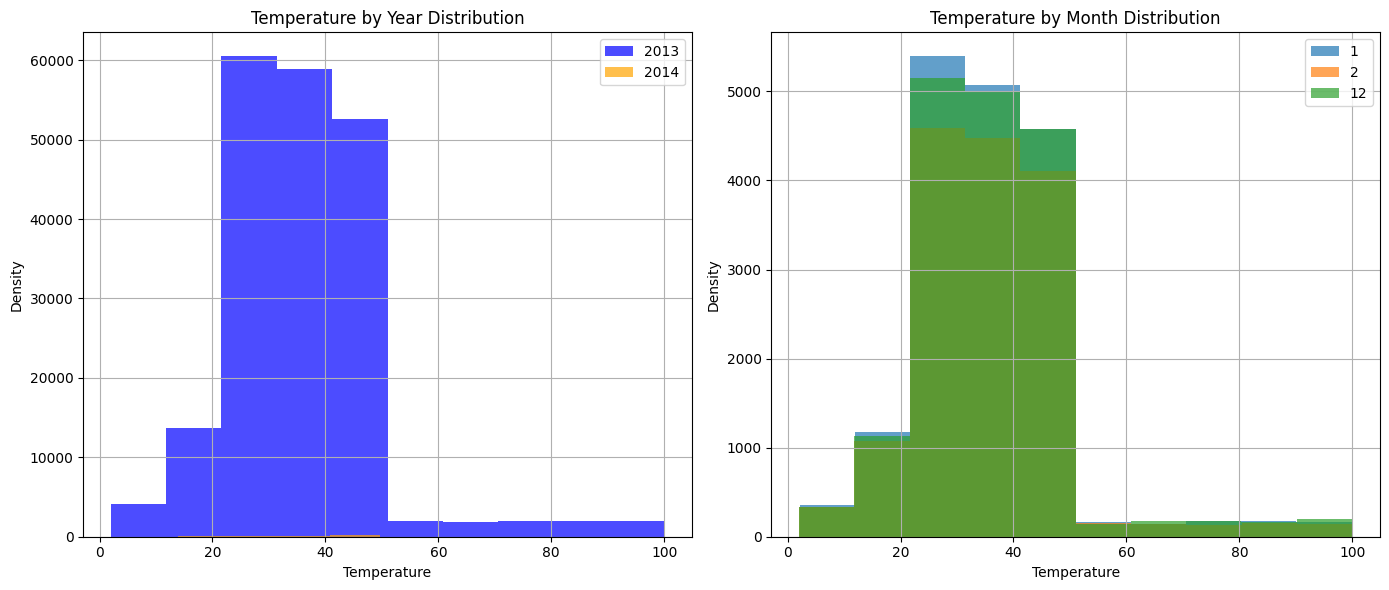

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature by Year Distribution
axes[0].hist(df[df['year'] == 2023]['temperature'], bins=10, alpha=0.7, label='2013', color='blue')
axes[0].hist(df[df['year'] == 2024]['temperature'], bins=10, alpha=0.7, label='2014', color='orange')
axes[0].set_title("Temperature by Year Distribution")
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# Temperature by Month Distribution
for month in [1, 2, 12]:
    axes[1].hist(df[df['month'] == month]['temperature'], bins=10, alpha=0.7, label=str(month))
axes[1].set_title("Temperature by Month Distribution")
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

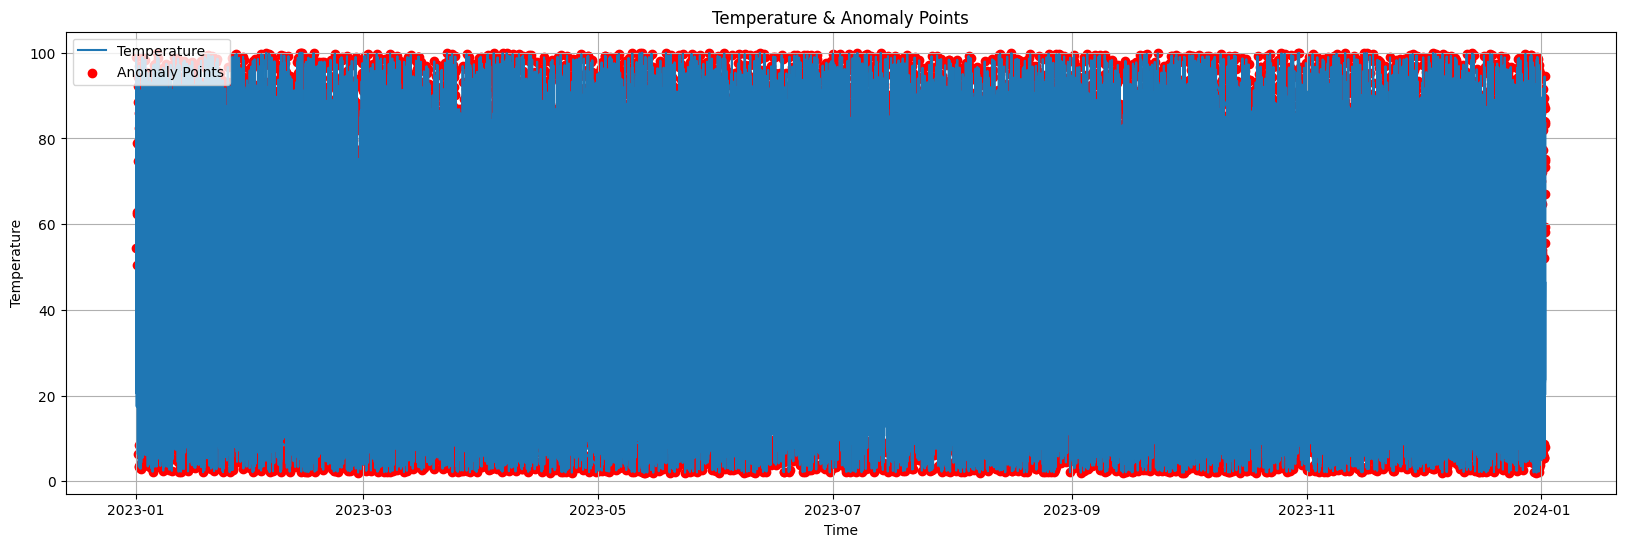

In [ ]:
import matplotlib.pyplot as plt

# Extract anomaly points
anomaly_indices = df[df['anomaly'] == 1].index
anomaly_values = df.loc[df['anomaly'] == 1, 'temperature']

plt.figure(figsize=(20, 6))
plt.plot(df.index, df['temperature'], label="Temperature")

# Plot anomaly points
plt.scatter(anomaly_indices, anomaly_values, color='red', label="Anomaly Points")

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature & Anomaly Points")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
df.head()

,temperature,anomaly,year,month,day,hour,minute,predicted_anomaly
timestamp,,,,,,,,
2023-01-01 00:01:00,28.394896,0,2023,1,1,0,1,-1
2023-01-01 00:02:00,98.954528,1,2023,1,1,0,2,-1
2023-01-01 00:11:00,32.103059,0,2023,1,1,0,11,-1
2023-01-01 00:20:00,31.011109,0,2023,1,1,0,20,-1
2023-01-01 00:22:00,26.024300,0,2023,1,1,0,22,-1


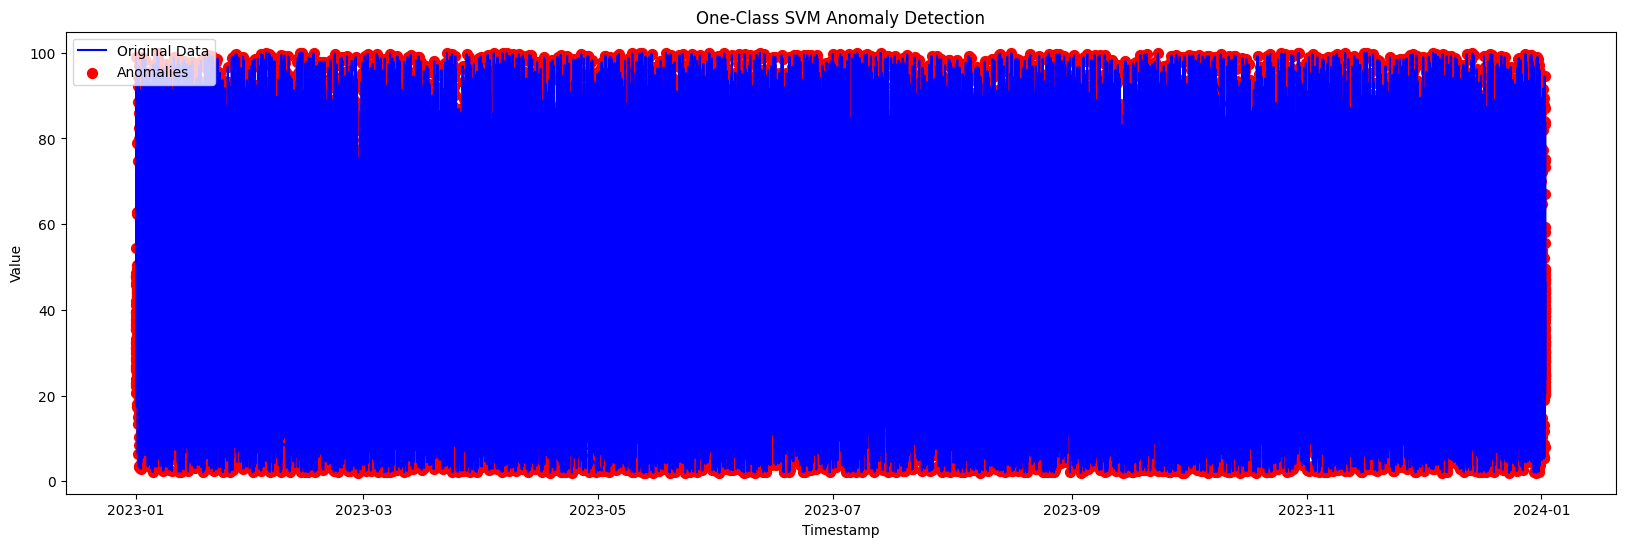

Precision: 0.33
Recall: 1.00
F1 Score: 0.50
Accuracy: 0.87


In [ ]:

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

df.index = pd.to_datetime(df.index)

selected_features = ['temperature', 'anomaly', 'year', 'month', 'day', 'hour', 'minute']
X = df[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.001)
clf.fit(X_scaled)

y_pred = clf.predict(X_scaled)

df['predicted_anomaly'] = y_pred

plt.figure(figsize=(20, 6))
plt.plot(df.index, df['temperature'], label='Original Data', color='blue')
plt.scatter(df[df['predicted_anomaly'] == -1].index, df[df['predicted_anomaly'] == -1]['temperature'],
            label='Anomalies', color='red', s=50)
plt.title('One-Class SVM Anomaly Detection')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

true_labels = df['anomaly']

precision = precision_score(true_labels, df['predicted_anomaly'] == -1)
recall = recall_score(true_labels, df['predicted_anomaly'] == -1)
f1 = f1_score(true_labels, df['predicted_anomaly'] == -1)
accuracy = accuracy_score(true_labels, df['predicted_anomaly'] == -1)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

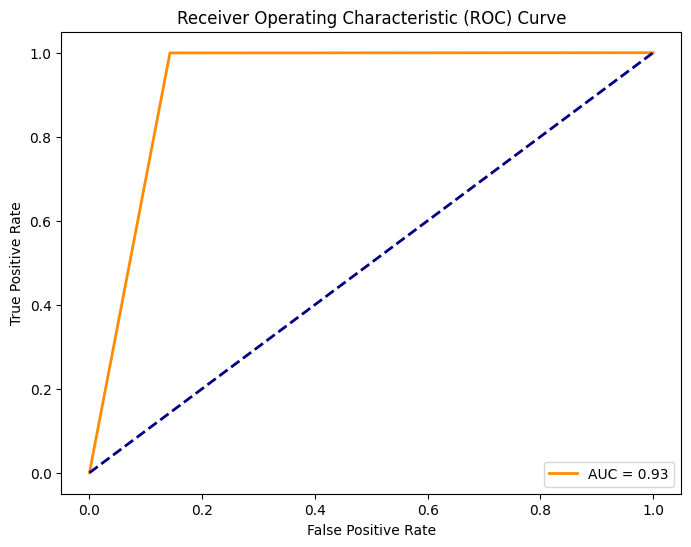

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(df['anomaly'], df['predicted_anomaly'] == -1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Squared Anomaly Score
rmse_anomaly = np.sqrt(mean_squared_error(df['temperature'], df['temperature'] * (df['predicted_anomaly'] == -1)))
print(f'Root Mean Squared Anomaly Score: {rmse_anomaly:.2f}')

# Calculate Mean Absolute Anomaly Score
mae_anomaly = mean_absolute_error(df['temperature'], df['temperature'] * (df['predicted_anomaly'] == -1))
print(f'Mean Absolute Anomaly Score: {mae_anomaly:.2f}')


Root Mean Squared Anomaly Score: 32.35
Mean Absolute Anomaly Score: 28.09


In [ ]:
results_table = pd.DataFrame({
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'Accuracy': [accuracy]
})

print(results_table)

   Precision    Recall  F1 Score  Accuracy
0   0.333525  0.999476   0.50015   0.86667


In [ ]:
import time
window_size = 100

data_buffer = []

# take real-time data from censors
def real_time_data_source():

    import random
    while True:
        if random.random() < 0.7:
            yield random.uniform(70, 90)
        else:
            yield random.uniform(60, 70)

collection_duration = 10

start_time = time.time()

threshold = 0.0

normal_count = 0
anomaly_count = 0
while time.time() - start_time < collection_duration:
    new_data_point = next(real_time_data_source())

    data_buffer.append(new_data_point)

    if len(data_buffer) > window_size:
        data_buffer.pop(0)

    if len(data_buffer) >= window_size:
        data_array = np.array(data_buffer).reshape(-1, 1)

        clf.fit(data_array)

        anomaly_score = clf.decision_function(data_array[-1].reshape(1, -1))

        if anomaly_score < threshold:
            status = "Normal"
            normal_count += 1
        else:
            status = "Anomaly detected!"
            anomaly_count += 1

        print(f"Data Point: {data_array[-1][0]:.2f}, Status: {status}, Anomaly Score: {anomaly_score[0]:.2f}")


total_data_points = normal_count + anomaly_count
normal_ratio = normal_count / total_data_points
anomaly_ratio = anomaly_count / total_data_points


# print Anomaly score and Anomaly ratio

print(f"Normal Data Points: {normal_count}, \n Anomaly Data Points: {anomaly_count}")
print(f"Normal Ratio: {normal_ratio:.2f}, \n Anomaly Ratio: {anomaly_ratio:.2f}")

Streaming output truncated to the last 5000 lines.
Data Point: 80.63, Status: Anomaly detected!, Anomaly Score: 1.34
Data Point: 67.17, Status: Anomaly detected!, Anomaly Score: 0.97
Data Point: 82.17, Status: Anomaly detected!, Anomaly Score: 1.15
Data Point: 65.86, Status: Anomaly detected!, Anomaly Score: 0.75
Data Point: 63.42, Status: Anomaly detected!, Anomaly Score: 0.25
Data Point: 65.85, Status: Anomaly detected!, Anomaly Score: 0.74
Data Point: 70.05, Status: Anomaly detected!, Anomaly Score: 1.36
Data Point: 62.09, Status: Normal, Anomaly Score: -0.07
Data Point: 79.34, Status: Anomaly detected!, Anomaly Score: 1.46
Data Point: 74.67, Status: Anomaly detected!, Anomaly Score: 1.61
Data Point: 73.77, Status: Anomaly detected!, Anomaly Score: 1.59
Data Point: 73.78, Status: Anomaly detected!, Anomaly Score: 1.59
Data Point: 86.20, Status: Anomaly detected!, Anomaly Score: 0.43
Data Point: 79.62, Status: Anomaly detected!, Anomaly Score: 1.43
Data Point: 76.17, Status: Anomaly 